# **Non-compartmental-clearance, IV Infusion/Bolus Model:**

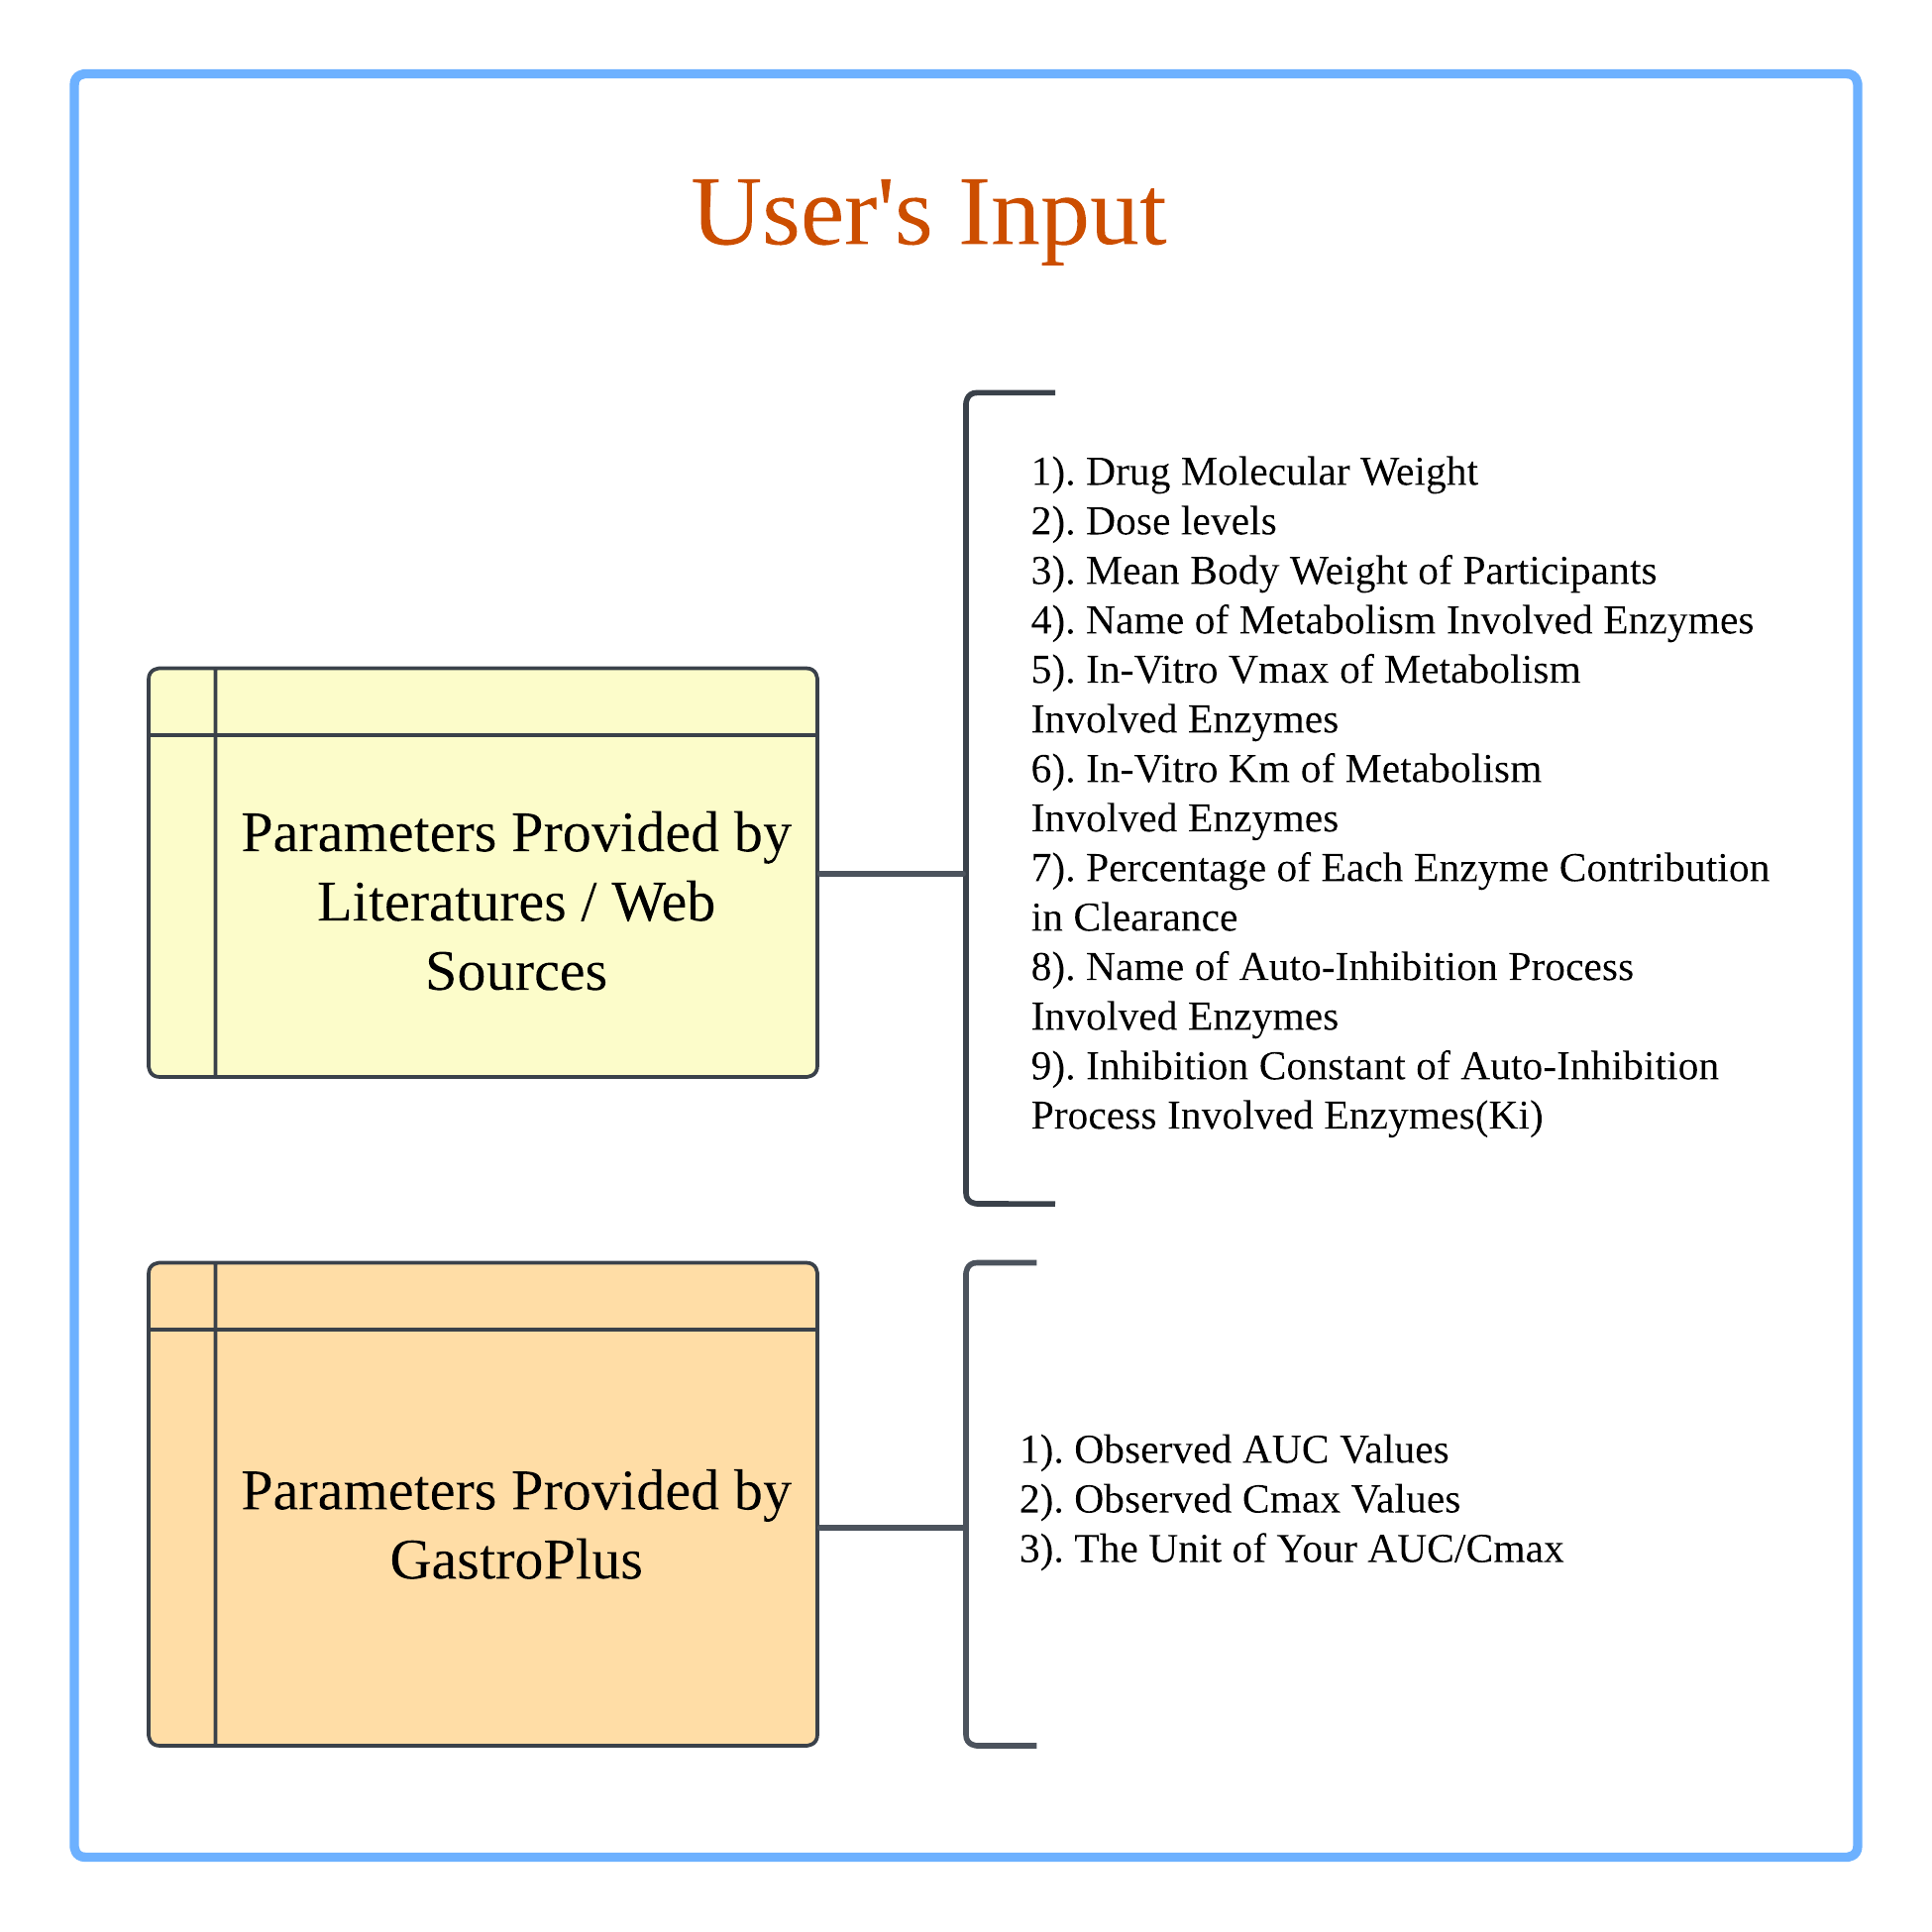

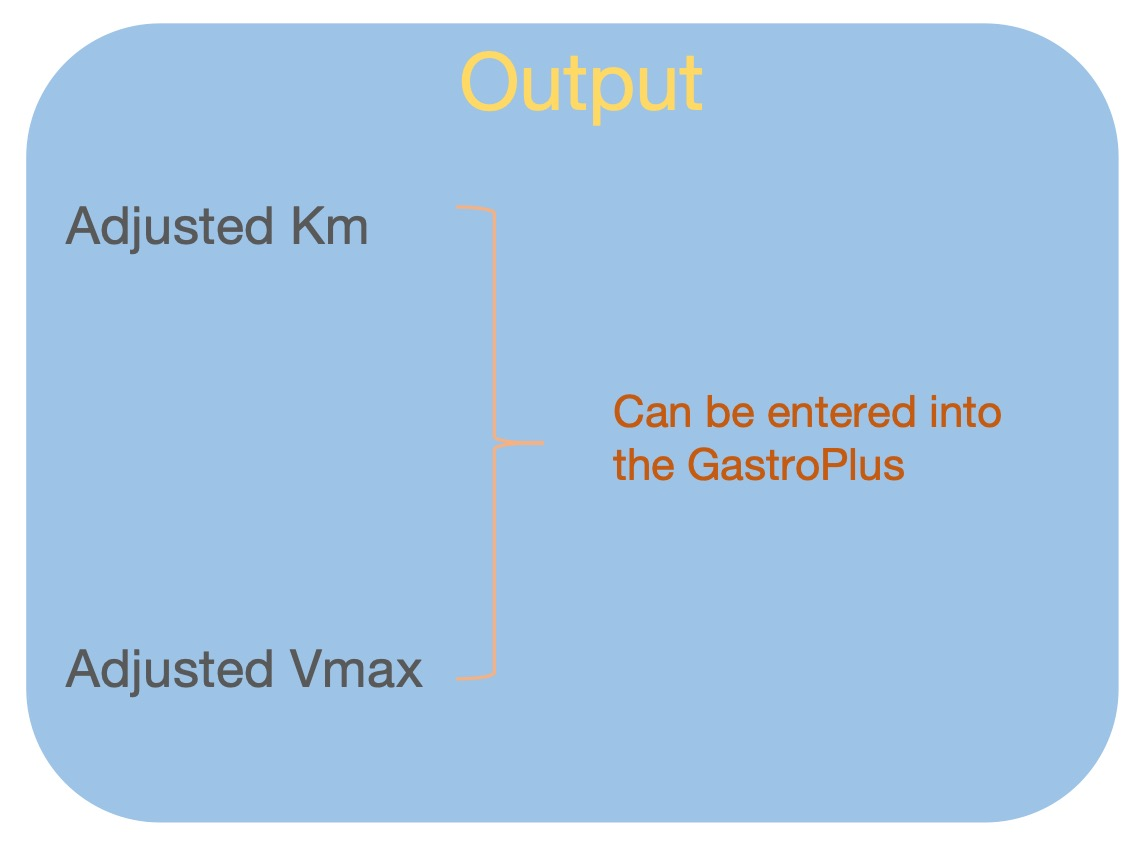


## **Main Execution Section**

**Please run the following code block at first;**

**And then enter your values:**

In [ ]:
import numpy as np
import math
from scipy.optimize import minimize

class GastroPlusSimulation:
    def __init__(self, auc_unit):
        self.auc_unit = auc_unit

    def convert_clint(self, clint):
        if self.auc_unit == "(ng x h) / ml":
            return clint * 1000
        elif self.auc_unit == "(μg x h) / ml":
            return clint
        else:
            raise ValueError(f"Unrecognized AUC unit: {self.auc_unit}")

    def convert_cmax(self, cmax):
        converted_cmax = {}
        for key, value in cmax.items():
            if self.auc_unit == "(ng x h) / ml":
                converted_cmax[key] = value
            elif self.auc_unit == "(μg x h) / ml":
                converted_cmax[key] = value * 1000
            else:
                raise ValueError(f"Unrecognized AUC unit: {self.auc_unit}")
        return converted_cmax

    def calculate_total_clint(self, observed_auc):
        total_clint_collection = {}
        for dose, auc_value in observed_auc.items():
            clint = int(dose) / auc_value
            adjusted_clint = self.convert_clint(clint)
            total_clint_collection[dose] = adjusted_clint
        return total_clint_collection

class EnzymeKinetics:
    def __init__(self, molecular_weight, enzyme_kms, enzyme_kis, contributions):
        self.molecular_weight = molecular_weight
        self.enzyme_kms = enzyme_kms
        self.enzyme_kis = enzyme_kis
        self.contributions = contributions

    def calculate_inhibition_factors(self, cmax):
        inhibition_factors = {}
        for cmax_value in cmax.values():
            factors = []
            for name, ki_value in self.enzyme_kis.items():
                factor = round(1 + (cmax_value / (ki_value * self.molecular_weight)), 2)
                factors.append((name, factor))
            inhibition_factors[cmax_value] = factors
        return inhibition_factors

    def adjust_km(self, cmax):
        modified_kms = {}
        inhibition_factors = self.calculate_inhibition_factors(cmax)
        for cmax_key, factors_collection in inhibition_factors.items():
            adjusted_values = []
            # Adjust Km for each enzyme based on inhibition factor
            for an_enzyme, a_factor in factors_collection:
                original_km = self.enzyme_kms.get(an_enzyme, 0)
                adjusted_values.append((an_enzyme, round(original_km * a_factor, 2)))
            # Add any enzymes not in adjusted_values
            for key in self.enzyme_kms:
                if key not in [name for name, _ in adjusted_values]:
                   adjusted_values.append((key,enzyme_kms[key]))

            modified_kms[cmax_key] = adjusted_values
        return modified_kms

class ClearanceCalculator:
    def __init__(self, mean_body_weight):
        self.mean_body_weight = mean_body_weight
        self.liver_weight = round(mean_body_weight * 0.0225 * 1000, 1)
        self.microsomal_protein = self.liver_weight * 38
        self.unit_converter = 0.000001 * 60

    def calculate_invitro_vmax(self, vmax_lit, km_lit):
        clint_values = {}
        for enzyme, vmax in vmax_lit.items():
            km = km_lit.get(enzyme, 0)
            if km:
                clint = round((vmax * self.microsomal_protein / km) * self.unit_converter, 8)
                clint_values[enzyme] = clint
        total_clint = round(sum(clint_values.values()), 6)
        return clint_values, total_clint

    def assign_contributions(self, adjusted_km, contributions):
        contribution_collection = {}
        for cmax_key, km_values in adjusted_km.items():
            total_km_sum = sum(km for _, km in km_values)
            enzyme_contributions = []
            for enzyme, km in km_values:
                base_contribution = contributions.get(enzyme, 0)
                adjusted_contribution = round(base_contribution * math.log(total_km_sum / km), 2)
                enzyme_contributions.append((enzyme, adjusted_contribution))
            contribution_collection[cmax_key] = enzyme_contributions
        return contribution_collection

    def normalize_contributions(self, contributions):
        normalized_contributions = {}
        for cmax_key, enzyme_contributions in contributions.items():
            total_contribution = sum(c[1] for c in enzyme_contributions)
            normalized_contributions[cmax_key] = [
                (enzyme, round(contribution / total_contribution, 2))
                for enzyme, contribution in enzyme_contributions
            ]
        return normalized_contributions

    def calculate_vmax(self, normalized_contributions, total_clint, adjusted_km):
        vmax_collection = {}
        for cmax_key, contributions in normalized_contributions.items():
            vmax_values = []
            for enzyme, percentage in contributions:
                clint = percentage * total_clint
                km = dict(adjusted_km[cmax_key]).get(enzyme, 0)
                vmax = round((clint * km / 3600), 8)
                vmax_values.append((enzyme, vmax))
            vmax_collection[cmax_key] = vmax_values
        return vmax_collection


############ MAIN EXECUTION ############
if __name__ == "__main__":
    ###### Input Drug's Basic Information ######
    Drur_Info = {}
    drug_Name = input("Please input your drug's name: ")
    Molecular_Weight = float(input("Please input your drug molecular weight(g/mol): "))
    Drur_Info[drug_Name] = Molecular_Weight
    print(f"{drug_Name} molecular weight is: {Molecular_Weight} g/mol")

    ###### Input the Unit of AUC ######
    def get_auc_unit():
        while True:
            print("Please select the unit of AUC used in your GastroPlus simulation:")
            print("1. (ng x h) / ml")
            print("2. (μg x h) / ml")

            choice = input("Enter 1 or 2: ").strip()

            if choice == '1':
               return "(ng x h) / ml"
            elif choice == '2':
               return "(μg x h) / ml"
        else:
             print("Invalid input. Please enter either 1 or 2.")
    auc_unit = get_auc_unit()
    print(f"Selected AUC unit: {auc_unit}")

    ###### Input Mean Body Weight ######
    Mean_body_weight = float(input("Please input your mean body weight(kg): "))
    print(f"Your mean body weight is: {Mean_body_weight} kg")

    ###### Input Dose Levels ######
    while True:
        try:
            example_dose = input("Please input your dose levels (mg), seperated by commas (e.g. 400,100,50): ")
            example_dose = [int(i.strip()) for i in example_dose.split(',')]
            print("\nDose levels available (in mg):", example_dose)
            break
        except ValueError:
            print("Invalid input. Please enter dose levels separated by commas.")

    ###### Input Observed AUCs from GastroPlus ######
    observed_auc = {}

    for dose in example_dose:
        auc_value = float(input(f"Please input observed AUC value for dose {dose} mg provided by GastroPlus: "))
        observed_auc[dose] = auc_value

    print("\nObserved AUC values from GastroPlus:")
    for dose, auc_value in observed_auc.items():
        print(f"Dose Level-{dose}: AUC={auc_value}")

    ###### Input Dose-Corresponding Cmax from GastroPlus ######
    Cmax = {}

    for dose in example_dose:
        cmax_value = float(input(f"Please enter the Cmax value that corresponding to your dose level-{dose} mg: "))
        Cmax[dose] = cmax_value

    print("\nDose-Corresponding Cmax values from GastroPlus:")
    for dose, cmax_value in Cmax.items():
        print(f"Dose Level-{dose} mg: Cmax={cmax_value}")

    ###### Input Km that GastroPlus Converted from Your Literatures ######
    Enzyme_kms_converted_by_GP = {}

    number_of_involved_enzymes = int(input("\nHow many kinds of enzymes are involved in your simulation? "))
    for i in range(number_of_involved_enzymes):
        enzyme_names = input(f"Please enter the name of enzyme {i+1}: ")
        enzyme_kms = input(f"Please enter the Km provided by the GastroPlus, the unit should be mg/L {i+1}: ")
        Enzyme_kms_converted_by_GP[enzyme_names] = enzyme_kms

    print("\nEnzyme-Corresponding Km values from GastroPlus:")
    for enzyme_names, enzyme_kms in Enzyme_kms_converted_by_GP.items():
        print(f"Enzyme Name:{enzyme_names}: Km={enzyme_kms}")

    ###### Input in vitro Km from your Literatures ######
    Km_from_Literature = {}
    for index, enzyme_names in enumerate(Enzyme_kms_converted_by_GP.keys()):
        literature_km = float(input(f"Please enter the in vitro Km provided by the literatures, the unit should be μmol/L {enzyme_names}: "))
        Km_from_Literature[enzyme_names] = literature_km

    print("\nEnzyme-Corresponding Km values from Literatures:")
    for enzyme_names, enzyme_kms_from_literatures in Km_from_Literature.items():
        print(f"Enzyme Name:{enzyme_names}: Km={enzyme_kms_from_literatures}")

    ###### Input in vitro Vmax from your Literatures ######
    Vmax_from_Literature = {}
    for index, enzyme_names in enumerate(Enzyme_kms_converted_by_GP.keys()):
        literature_vmax = float(input(f"Please enter the in vitro Vmax provided by the literatures, the unit should be pmol/min {enzyme_names}: "))
        Vmax_from_Literature[enzyme_names] = literature_vmax

    print("\nEnzyme-Corresponding Vmax values from Literatures:")
    for enzyme_names, enzyme_vmax_from_literatures in Vmax_from_Literature.items():
        print(f"Enzyme Name:{enzyme_names}: Km={enzyme_vmax_from_literatures}")

    ###### Input Enzyme Contribution from Literatures ######
    Enzyme_Contribution_from_Literature = {}
    for index, enzyme_names in enumerate(Enzyme_kms_converted_by_GP.keys()):
        contribution = float(input(f"Please enter the contribution of enzyme in the metabolism process (e.g. 0.2, 0.1): {enzyme_names}"))
        Enzyme_Contribution_from_Literature[enzyme_names] = contribution

    print("\nEnzyme-Corresponding contribution from Literatures:")
    for enzyme_names, enzyme_vmax_from_literatures in Vmax_from_Literature.items():
        print(f"Enzyme Name:{enzyme_names}: Km={enzyme_vmax_from_literatures}")

    ###### Input Ki (inhbitor constant) from Literatures; PLEASE NOTIFY the unit should only be umol/L ######
    Enzyme_inhibition_Constant = {}
    names_of_enzymes_inhibited = input("\nPlease input the name of enzymes auto-inhibited by your drug, seperated by commas (e.g., CYP3A4,CYP2C9): ")
    names_of_enzymes_inhibited = [str(j.strip()) for j in names_of_enzymes_inhibited.split(',')]
    for name in names_of_enzymes_inhibited:
        Ki_value = float(input(f"Please enter the inhibition constant Ki provided by the literatures, the unit should only be μmol/L {name}: "))
        Enzyme_inhibition_Constant[name] = Ki_value

**Run the following codeblock to execute the calculation process:**

In [ ]:
simulation = GastroPlusSimulation(auc_unit)
kinetics = EnzymeKinetics(molecular_weight, enzyme_kms, enzyme_kis, enzyme_contributions)
clearance_calc = ClearanceCalculator(mean_body_weight)

# Calculate total clearance from observed AUC
total_clint = simulation.calculate_total_clint(observed_auc)
print(f"Total CLint (observed): {total_clint}")

# Convert Cmax values based on AUC unit
converted_cmax = simulation.convert_cmax(cmax_values)
print(f"Converted Cmax values: {converted_cmax}")

# Calculate inhibition factors
inhibition_factors = kinetics.calculate_inhibition_factors(converted_cmax)
print(f"Inhibition Factors: {inhibition_factors}")

# Adjust Km values
adjusted_km = kinetics.adjust_km(converted_cmax)
print(f"Adjusted Km values: {adjusted_km}")

# Calculate in-vitro Vmax and total clearance
clint_values, total_clint_invitro = clearance_calc.calculate_invitro_vmax(vmax_lit,km_lit)
print(f"In-vitro Clint values: {clint_values}")
print(f"Total in-vitro CLint: {total_clint_invitro}")

# Assign contributions of clearance to enzymes
enzyme_contributions_adjusted = clearance_calc.assign_contributions(adjusted_km, enzyme_contributions)
print(f"Enzyme contributions (adjusted): {enzyme_contributions_adjusted}")

# Normalize contributions
normalized_contributions = clearance_calc.normalize_contributions(enzyme_contributions_adjusted)
print(f"Normalized enzyme contributions: {normalized_contributions}")

# Calculate Vmax
vmax_values = clearance_calc.calculate_vmax(normalized_contributions, total_clint_invitro, adjusted_km)
print(f"Vmax values: {vmax_values}")

## **Example: Voriconazole**




In [4]:
import json

# Collect the inputs (this would be your actual input collection code)
inputs = {
    "auc_unit": "(ng x h) / ml",  # Example input, use your actual values
    "drug_name": "Voriconazole",
    "Molecular_Weight": 349.3,
    "example_dose": [400, 100, 50],
    "observed_auc": {400: 19430, 100: 2734.6, 50: 1158.1},
    "Cmax": {400: 2600, 100: 508, 50: 334.3},

    "Enzyme_kms_converted_by_GP": {
        "CYP3A4": 62.99,
        "CYP2C9": 5.361,
        "CYP2C19": 0.938,
        "FMOs": 804.13
    },

    "Enzyme_inhibition_Constant": {
        "CYP3A4": 0.15,
        "CYP2C9": 2.79,
        "CYP2C19": 5.1
    },

    "Mean_body_weight": 80.8,

    "Vmax_from_Literature": {
        "CYP3A4": 0.14,
        "CYP2C9": 0.056,
        "CYP2C19": 0.39,
        "FMOs": 0.025
    },

    "Km_from_Literature": {
        "CYP3A4": 235,
        "CYP2C9": 20,
        "CYP2C19": 3.5,
        "FMOs": 3000
    },

    "Enzyme_Contribution_from_Literature": {
        "CYP3A4": 0.2,
        "CYP2C9": 0.1,
        "CYP2C19": 0.5,
        "FMOs": 0.2
    }

}

# Save the inputs to a JSON file
with open('inputs.json', 'w') as f:
    json.dump(inputs, f)

print("Inputs have been saved to 'inputs.json'.")

Inputs have been saved to 'inputs.json'.


In [8]:
# Load the inputs from the 'inputs.json' file
with open('inputs.json', 'r') as f:
    inputs = json.load(f)

# Step 2: Parse the JSON data into variables
auc_unit = inputs["auc_unit"]
molecular_weight = inputs["Molecular_Weight"]
observed_auc = inputs["observed_auc"]
cmax_values = inputs["Cmax"]
enzyme_kms = inputs["Enzyme_kms_converted_by_GP"]
enzyme_kis = inputs["Enzyme_inhibition_Constant"]
enzyme_contributions = inputs["Enzyme_Contribution_from_Literature"]
mean_body_weight = inputs["Mean_body_weight"]
vmax_lit = inputs["Vmax_from_Literature"]
km_lit = inputs["Km_from_Literature"]

simulation = GastroPlusSimulation(auc_unit)
kinetics = EnzymeKinetics(molecular_weight, enzyme_kms, enzyme_kis, enzyme_contributions)
clearance_calc = ClearanceCalculator(mean_body_weight)

# Calculate total clearance from observed AUC
total_clint = simulation.calculate_total_clint(observed_auc)
print(f"Total CLint (observed): {total_clint}")

# Convert Cmax values based on AUC unit
converted_cmax = simulation.convert_cmax(cmax_values)
print(f"Converted Cmax values: {converted_cmax}")

# Calculate inhibition factors
inhibition_factors = kinetics.calculate_inhibition_factors(converted_cmax)
print(f"Inhibition Factors: {inhibition_factors}")

# Adjust Km values
adjusted_km = kinetics.adjust_km(converted_cmax)
print(f"Adjusted Km values: {adjusted_km}")

# Calculate in-vitro Vmax and total clearance
clint_values, total_clint_invitro = clearance_calc.calculate_invitro_vmax(vmax_lit,km_lit)
print(f"In-vitro Clint values: {clint_values}")
print(f"Total in-vitro CLint: {total_clint_invitro}")

# Assign contributions of clearance to enzymes
enzyme_contributions_adjusted = clearance_calc.assign_contributions(adjusted_km, enzyme_contributions)
print(f"Enzyme contributions (adjusted): {enzyme_contributions_adjusted}")

# Normalize contributions
normalized_contributions = clearance_calc.normalize_contributions(enzyme_contributions_adjusted)
print(f"Normalized enzyme contributions: {normalized_contributions}")

# Calculate Vmax
vmax_values = clearance_calc.calculate_vmax(normalized_contributions, total_clint_invitro, adjusted_km)
print(f"Vmax values: {vmax_values}")

Total CLint (observed): {'400': 20.58672156459084, '100': 36.56841951290865, '50': 43.17416457991538}
Converted Cmax values: {'400': 2600, '100': 508, '50': 334.3}
Inhibition Factors: {2600: [('CYP3A4', 50.62), ('CYP2C9', 3.67), ('CYP2C19', 2.46)], 508: [('CYP3A4', 10.7), ('CYP2C9', 1.52), ('CYP2C19', 1.29)], 334.3: [('CYP3A4', 7.38), ('CYP2C9', 1.34), ('CYP2C19', 1.19)]}
Adjusted Km values: {2600: [('CYP3A4', 3188.55), ('CYP2C9', 19.67), ('CYP2C19', 2.31), ('FMOs', 804.13)], 508: [('CYP3A4', 673.99), ('CYP2C9', 8.15), ('CYP2C19', 1.21), ('FMOs', 804.13)], 334.3: [('CYP3A4', 464.87), ('CYP2C9', 7.18), ('CYP2C19', 1.12), ('FMOs', 804.13)]}
In-vitro Clint values: {'CYP3A4': 0.00246939, 'CYP2C9': 0.01160611, 'CYP2C19': 0.46187589, 'FMOs': 3.454e-05}
Total in-vitro CLint: 0.475986
Enzyme contributions (adjusted): {2600: [('CYP3A4', 0.05), ('CYP2C9', 0.53), ('CYP2C19', 3.73), ('FMOs', 0.32)], 508: [('CYP3A4', 0.16), ('CYP2C9', 0.52), ('CYP2C19', 3.56), ('FMOs', 0.12)], 334.3: [('CYP3A4', 0.